# Test classifiers

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import dill as pickle

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import cross_validate

#from src.data import processing as dat
#from src.features import variableimp as vimp
#from src.visualization import features as ftplt

#from sklearn.model_selection import StratifiedKFold
#from sklearn import metrics
#from sklearn.inspection import permutation_importance

In [2]:
### Read VT data
data_df = pd.read_pickle("../data/interim/vtdata.pkl")
data_df = data_df.sample(frac=1, random_state=7).reset_index(drop=True)

vt_X = data_df.drop(columns="vt")
vt_y = data_df["vt"]

### ...and drop unwanted features to avoid spatial overfitting
vt_X = vt_X.drop(['x', 'y', 'plot_id'], axis=1)
print(vt_X.columns)
vt_X.head()

Index(['B11_median_comp_Sent2', 'B12_median_comp_Sent2',
       'B1_median_comp_Sent2', 'B2_median_comp_Sent2', 'B3_median_comp_Sent2',
       'B4_median_comp_Sent2', 'B5_median_comp_Sent2', 'B6_median_comp_Sent2',
       'B7_median_comp_Sent2', 'B8A_median_comp_Sent2', 'B8_median_comp_Sent2',
       'B9_median_comp_Sent2', 'EVI_greenest_pixel_Sent2',
       'EVI_median_comp_Sent2', 'GNDVI_greenest_pixel_Sent2',
       'GNDVI_median_comp_Sent2', 'NDMI_greenest_pixel_Sent2',
       'NDMI_median_comp_Sent2', 'NDVI_greenest_pixel_Sent2',
       'NDVI_median_comp_Sent2', 'SAVI_greenest_pixel_Sent2',
       'SAVI_median_comp_Sent2', 'B1_median_comp_Lands7',
       'B2_median_comp_Lands7', 'B3_median_comp_Lands7',
       'B4_median_comp_Lands7', 'B5_median_comp_Lands7',
       'B6_median_comp_Lands7', 'B7_median_comp_Lands7',
       'EVI_greenest_pixel_Lands7', 'EVI_median_comp_Lands7',
       'GNDVI_greenest_pixel_Lands7', 'GNDVI_median_comp_Lands7',
       'NDMI_greenest_pixel_Lands7', 'ND

,B11_median_comp_Sent2,B12_median_comp_Sent2,B1_median_comp_Sent2,B2_median_comp_Sent2,B3_median_comp_Sent2,B4_median_comp_Sent2,B5_median_comp_Sent2,B6_median_comp_Sent2,B7_median_comp_Sent2,B8A_median_comp_Sent2,...,tmax_6,tmax_8,tmax_9,tmin_5,tmin_9,topographic_wetness_index,total_insolation,valley_depth,vertical_distance_to_channel_network,visible_sky
0,0.21700,0.12775,0.04157,0.04070,0.05858,0.05915,0.10155,0.17385,0.19245,0.21790,...,20.5811,18.1146,12.9765,-4.5616,-1.6503,8.1780,1168.90918,121.9962,163.3139,94.1729
1,0.07680,0.03780,0.01560,0.01945,0.02982,0.01820,0.04752,0.12807,0.15217,0.16735,...,22.5382,20.2714,17.2824,0.7850,0.4542,6.8749,1211.49475,64.2473,25.2764,97.7724
2,0.20360,0.09220,0.06630,0.03990,0.06280,0.04020,0.12070,0.31450,0.35760,0.38720,...,17.6708,20.3218,14.5407,-3.4983,-2.3515,17.6024,993.73572,748.6170,0.0000,84.9623
3,0.22508,0.13655,0.02765,0.04070,0.06180,0.06697,0.11375,0.22545,0.25670,0.29110,...,21.9165,20.5618,15.8932,2.0480,4.8671,7.2655,1118.61890,103.4937,46.4838,94.7372
4,0.24625,0.13610,0.03075,0.04715,0.07305,0.07145,0.14155,0.25710,0.28145,0.31650,...,14.7530,16.7801,13.4581,-7.0645,-1.2334,7.3559,1399.06226,229.2504,62.1383,94.1043


In [3]:
# Load CV indices
with open('../data/misc/vtdata_5f_spatial_cv_indices.pkl', 'rb') as file:
    split_indices = pickle.load(file)

split_indices

[(array([    0,     1,     3, ..., 22168, 22169, 22170]),
  array([    2,     7,     9, ..., 22157, 22171, 22172])),
 (array([    0,     1,     2, ..., 22170, 22171, 22172]),
  array([   14,    58,    67, ..., 22158, 22166, 22167])),
 (array([    0,     1,     2, ..., 22168, 22171, 22172]),
  array([   11,    12,    23, ..., 22164, 22169, 22170])),
 (array([    0,     2,     4, ..., 22170, 22171, 22172]),
  array([    1,     3,     6, ..., 22163, 22165, 22168])),
 (array([    1,     2,     3, ..., 22170, 22171, 22172]),
  array([    0,     4,     5, ..., 22146, 22159, 22162]))]

In [4]:
scores = {
    'cohen_kappa': make_scorer(cohen_kappa_score),
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro'
}
scores

{'cohen_kappa': make_scorer(cohen_kappa_score),
 'accuracy': 'accuracy',
 'f1_macro': 'f1_macro'}

In [5]:
# Dummy classifier
dummy_clf = DummyClassifier(strategy="prior")

dummy_cv_default = cross_validate(
    estimator=dummy_clf,
    X=vt_X,
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=2
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.2s finished


In [6]:
dummy_cv_default

{'fit_time': array([0.01739335, 0.0149982 , 0.01437426, 0.01445723, 0.01228499]),
 'score_time': array([0.02290058, 0.02265453, 0.02529645, 0.02209258, 0.0247581 ]),
 'estimator': [DummyClassifier(),
  DummyClassifier(),
  DummyClassifier(),
  DummyClassifier(),
  DummyClassifier()],
 'test_cohen_kappa': array([0., 0., 0., 0., 0.]),
 'train_cohen_kappa': array([0., 0., 0., 0., 0.]),
 'test_accuracy': array([0.13957159, 0.12311161, 0.14002255, 0.14140731, 0.13328823]),
 'train_accuracy': array([0.1344571 , 0.13857256, 0.13434435, 0.13399853, 0.13602796]),
 'test_f1_macro': array([0.00790176, 0.00707204, 0.00792415, 0.00799281, 0.00758787]),
 'train_f1_macro': array([0.00764652, 0.00785208, 0.00764087, 0.00762353, 0.00772516])}

In [32]:
# Load CV results
pd.set_option('display.max_columns', None)

rf_optim_df = pd.read_csv(
    "../results/hyperparam_search/rf_5fcv_bayes_n50_optim.csv",
    index_col=0
)

nn_optim_df = pd.read_csv(
    "../results/hyperparam_search/nn_5fcv_bayes_n50_optim.csv",
    index_col=0
)

rf_optim_df.loc[rf_optim_df['rank_test_score']==1, :]
nn_optim_df.loc[nn_optim_df['rank_test_score']==1, :]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha_l1,param_alpha_l2,param_dropout_rate,param_n_hidden_layers,param_n_nodes_l1,param_n_nodes_l2,param_optim_name,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,rank_train_score
45,449.895993,49.415848,1.95603,0.884616,0.000191,0.0001,0.01,2,16,64,nadam,"OrderedDict([('alpha_l1', 0.000190723014940367...",0.430891,0.435626,0.446449,0.421741,0.457826,0.438506,0.01252,1,0.492502,0.49673,0.501691,0.491121,0.489092,0.494227,0.004494,8


<Axes: >

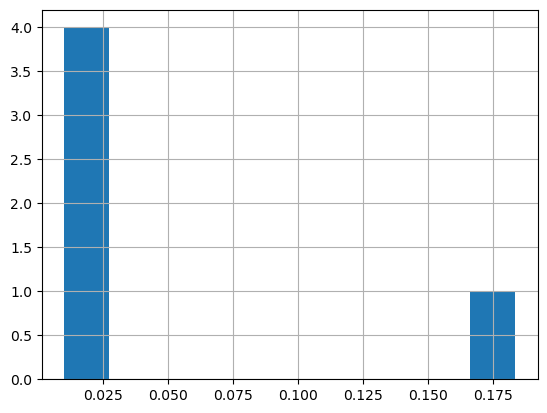

In [31]:
nn_optim_df.loc[rf_optim_df['rank_test_score']<=5]["param_dropout_rate"].hist()

## Random Forest

In [8]:
# Default parameters
# 10-Fold Cross validation, all predictors
rf_default = RandomForestClassifier(oob_score=True, n_jobs=10)

rf_cv_default = cross_validate(
    estimator=rf_default,
    X=vt_X,
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   3.0s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.1s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.4s finished


In [9]:
rf_cv_default

{'fit_time': array([2.85424304, 2.99347472, 2.85568619, 3.00798965, 2.90941167]),
 'score_time': array([0.07266021, 0.07998466, 0.08546185, 0.07626271, 0.07026577]),
 'estimator': [RandomForestClassifier(n_jobs=10, oob_score=True),
  RandomForestClassifier(n_jobs=10, oob_score=True),
  RandomForestClassifier(n_jobs=10, oob_score=True),
  RandomForestClassifier(n_jobs=10, oob_score=True),
  RandomForestClassifier(n_jobs=10, oob_score=True)],
 'test_cohen_kappa': array([0.44984077, 0.4363378 , 0.44519237, 0.43864905, 0.4366335 ]),
 'train_cohen_kappa': array([1.        , 0.99993974, 1.        , 0.99993977, 0.99993977]),
 'test_accuracy': array([0.49109357, 0.47869222, 0.48793687, 0.48173207, 0.47992783]),
 'train_accuracy': array([1.        , 0.99994362, 1.        , 0.99994363, 0.99994363]),
 'test_f1_macro': array([0.36387661, 0.34856554, 0.3411684 , 0.34006567, 0.3206695 ]),
 'train_f1_macro': array([1.        , 0.99992146, 1.        , 0.99991634, 0.99992228])}

## Hyperparameter tuning

In [8]:
optimized_rf = BayesSearchCV(
    estimator=RandomForestClassifier(oob_score=True, n_jobs=10),
    search_spaces={
        'n_estimators': Integer(50, 800),
        'criterion': Categorical(['gini', 'entropy']),
        'class_weight': Categorical(['balanced', None]),
        'max_depth': Integer(5, 30),  # integer valued parameter
        'max_features': Integer(
            int(np.sqrt(vt_X.shape[1])) - 3,
            int(np.sqrt(vt_X.shape[1])) + 3,
        ),
    },
    n_jobs=10,
    n_iter=50,
    cv=split_indices,
    random_state=221,
    verbose=2,
)

optimized_rf.fit(vt_X, vt_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=8, n_estimators=363; total time=   6.4s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=8, n_estimators=363; total time=   6.6s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=8, n_estimators=363; total time=   6.8s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=8, n_estimators=363; total time=   6.8s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=8, n_estimators=363; total time=   6.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=None, criterion=entropy, max_depth=21, max_features=9, n_estimators=409; total time=  34.3s
[CV] END class_weight=None, criterion=entropy, max_depth=21, max_features=9, n_estimators=409; total time=  34.4s
[CV] END class_weight=None, criterion=entropy, max_depth=21, max_features=9, n_estimators=409; tota

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=None, criterion=gini, max_depth=22, max_features=12, n_estimators=800; total time=  26.9s
[CV] END class_weight=None, criterion=gini, max_depth=22, max_features=12, n_estimators=800; total time=  27.5s
[CV] END class_weight=None, criterion=gini, max_depth=22, max_f

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.6min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=None, criterion=entropy, max_depth=23, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=None, criterion=entropy, max_depth=23, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=None, criterion=entropy, max_depth=

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=None, criterion=entropy, max_depth=

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=None, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.4min
[CV] END class_weight=None, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=None, criterion=entropy, max_depth=

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=12, n_estimators=800; total time= 1.5min


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_depth=26, max_features=12, n_estimators=800; total time= 1.5min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=19, max_features=6, n_estimators=794; total time=  46.5s
[CV] END class_weight=balanced, criterion=entropy, max_depth=19, max_features=6, n_estimators=794; total time=  46.9s
[CV] END class_weight=balanced, criterion=entropy, 

BayesSearchCV(cv=[(array([    0,     1,     3, ..., 22168, 22169, 22170]),
                   array([    2,     7,     9, ..., 22157, 22171, 22172])),
                  (array([    0,     1,     2, ..., 22170, 22171, 22172]),
                   array([   14,    58,    67, ..., 22158, 22166, 22167])),
                  (array([    0,     1,     2, ..., 22168, 22171, 22172]),
                   array([   11,    12,    23, ..., 22164, 22169, 22170])),
                  (array([    0,     2,     4, ..., 22170, 22171, 22172]),
                   array([    1,     3,     6, ..., 22163, 22165, 22168])),
                  (array([    1,     2,     3, ..., 2217...
              search_spaces={'class_weight': Categorical(categories=('balanced', None), prior=None),
                             'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=5, high=30, prior='uniform', transform='normalize'),
                             'max_features': Integer(low=6, high=12, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=800, prior='uniform', transform='normalize')},
              verbose=2)

In [34]:
print("val. score: %s" % optimized_rf.best_score_)
#print("test score: %s" % optimized_rf.score(X_test, y_test))
print("best params: %s" % str(optimized_rf.best_params_))

val. score: 0.4923104289443213
best params: OrderedDict([('class_weight', None), ('criterion', 'gini'), ('max_depth', 22), ('max_features', 12), ('n_estimators', 800)])


In [11]:
# Save pickle
import pickle
from pathlib import Path

try:
    if Path("../results/hyperparam_search/rf_5fcv_bayes_optim.pkl").is_file():

        raise Exception("DONT OVERWRITE THIS AGAIN")

    with open("../results/hyperparam_search/rf_5fcv_bayes_optim.pkl", 'wb') as pkl_file:
        pickle.dump(
            optimized_rf,
            pkl_file,
            protocol=pickle.HIGHEST_PROTOCOL
        )

    print("Saved pickle successfully.")

except Exception as e:
    print(e)

Saved pickle successfully.


In [33]:
# Load pickle
with open("../results/hyperparam_search/rf_5fcv_bayes_optim.pkl", 'rb') as pkl_file:
        optimized_rf = pickle.load(pkl_file)

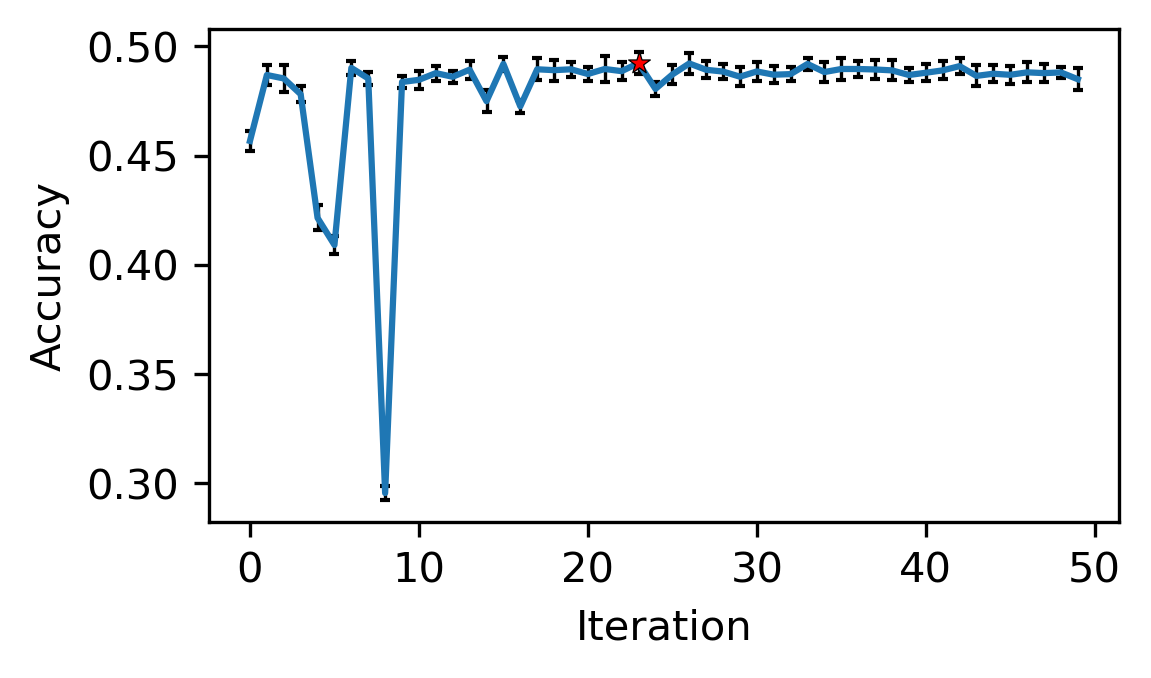

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10/2.54, 6/2.54), dpi=300)

ax.errorbar(
    x=range(len(optimized_rf.cv_results_['mean_test_score'])),
    y=optimized_rf.cv_results_['mean_test_score'],
    yerr=optimized_rf.cv_results_['std_test_score'],
    capsize=1.2,
    elinewidth=0.8,
    ecolor='black',
)

best_idx = [i for i in range(len(optimized_rf.cv_results_['rank_test_score'])) if optimized_rf.cv_results_['rank_test_score'][i] == 1]

ax.scatter(
    x=best_idx,
    y=optimized_rf.cv_results_['mean_test_score'][best_idx],
    s=30,
    marker='*',
    edgecolor="black",
    linewidth=0.3,
    color='red',
    zorder=3
)

ax.set_ylabel("Accuracy")
ax.set_xlabel("Iteration")

fig.tight_layout()
fig.savefig('../results/plots/bayes_cv_results.png')

In [6]:
# Print fitted vars
vars(optimized_rf)

{'search_spaces': {'n_estimators': Integer(low=50, high=800, prior='uniform', transform='normalize'),
  'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
  'class_weight': Categorical(categories=('balanced', None), prior=None),
  'max_depth': Integer(low=5, high=30, prior='uniform', transform='normalize'),
  'max_features': Integer(low=6, high=12, prior='uniform', transform='normalize')},
 'n_iter': 50,
 'n_points': 1,
 'random_state': 221,
 'optimizer_kwargs': None,
 'fit_params': None,
 'iid': 'deprecated',
 'scoring': None,
 'estimator': RandomForestClassifier(n_jobs=10, oob_score=True),
 'n_jobs': 2,
 'refit': True,
 'cv': [(array([    0,     1,     3, ..., 22168, 22169, 22170]),
   array([    2,     7,     9, ..., 22157, 22171, 22172])),
  (array([    0,     1,     2, ..., 22170, 22171, 22172]),
   array([   14,    58,    67, ..., 22158, 22166, 22167])),
  (array([    0,     1,     2, ..., 22168, 22171, 22172]),
   array([   11,    12,    23, ..., 22164, 22169,

In [8]:
optimized_rf.optimizer_results_[0]

          fun: -0.4928968679553659
            x: [None, 'entropy', 27, 12, 645]
    func_vals: [-4.540e-01 -4.887e-01 ... -4.911e-01 -4.908e-01]
      x_iters: [[None, 'gini', 10, 8, 363], [None, 'entropy', 21, 9, 409], ['balanced', 'entropy', 26, 7, 387], [None, 'entropy', 12, 8, 360], [None, 'entropy', 7, 10, 393], [None, 'gini', 6, 10, 610], [None, 'entropy', 25, 11, 665], [None, 'gini', 25, 11, 138], ['balanced', 'gini', 7, 10, 701], [None, 'entropy', 13, 9, 509], ['balanced', 'entropy', 30, 6, 800], [None, 'entropy', 30, 6, 800], [None, 'entropy', 17, 6, 594], [None, 'entropy', 28, 6, 800], ['balanced', 'gini', 28, 12, 50], [None, 'entropy', 30, 6, 576], ['balanced', 'entropy', 28, 6, 800], ['balanced', 'entropy', 28, 6, 800], ['balanced', 'entropy', 27, 6, 800], [None, 'gini', 30, 12, 800], [None, 'gini', 30, 6, 800], [None, 'gini', 30, 12, 50], [None, 'entropy', 16, 12, 50], [None, 'entropy', 27, 12, 683], [None, 'entropy', 27, 12, 658], [None, 'entropy', 27, 12, 633], [None, '

"\nax = plot_objective(\n    optimized_rf.optimizer_results_[0],\n    dimensions=['max_depth', 'max_features', 'n_estimators'],\n    n_minimum_search=int(1e8),\n)\n"

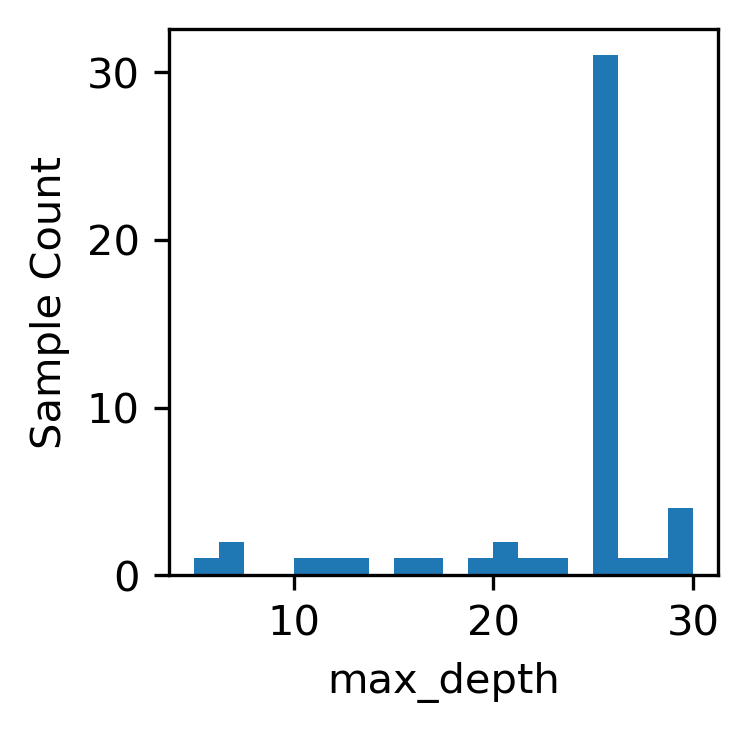

In [14]:
from skopt.plots import plot_objective, plot_histogram
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6/2.54, 6/2.54), dpi=300)

ax = plot_histogram(optimized_rf.optimizer_results_[0], 2)

'''
ax = plot_objective(
    optimized_rf.optimizer_results_[0],
    dimensions=['max_depth', 'max_features', 'n_estimators'],
    n_minimum_search=int(1e8),
)
'''

---
# Plot results

In [47]:
# Random Forest
rf_default = RandomForestClassifier(
    oob_score=True,
    random_state=221,
    n_jobs=10,
)

rf_cv_default = cross_validate(
    estimator=rf_default,
    X=vt_X,
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=5
)

# TUNED
rf_tuned = RandomForestClassifier(
    n_estimators=int(rf_optim_df.loc[rf_optim_df['rank_test_score']==1, 'param_n_estimators'].values),#645,
    class_weight=None,
    criterion=rf_optim_df.loc[rf_optim_df['rank_test_score']==1, 'param_criterion'].values[0],
    max_depth=int(rf_optim_df.loc[rf_optim_df['rank_test_score']==1, 'param_max_depth'].values[0]),#27,
    max_features=int(rf_optim_df.loc[rf_optim_df['rank_test_score']==1, 'param_max_features'].values[0]),#12,
    oob_score=True,
    random_state=221,
    n_jobs=10,
)

rf_cv_tuned = cross_validate(
    estimator=rf_tuned,
    X=vt_X,
    y=vt_y,
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=10
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   3.0s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.0s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.1s


[CV] END .................................................... total time=   3.0s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[CV] END .................................................... total time=  26.1s
[CV] END .................................................... total time=  26.2s
[CV] END .................................................... total time=  26.9s
[CV] END .................................................... total time=  28.0s
[CV] END .................................................... total time=  28.1s


[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   49.7s finished


In [45]:
rf_cv_tuned

{'fit_time': array([28.8559711 , 27.29724026, 25.91342473, 25.98991036, 25.57767415]),
 'score_time': array([0.32876873, 0.27014875, 0.25571132, 0.23977685, 0.23137331]),
 'estimator': [RandomForestClassifier(max_depth=22, max_features=12, n_estimators=800,
                         n_jobs=10, oob_score=True),
  RandomForestClassifier(max_depth=22, max_features=12, n_estimators=800,
                         n_jobs=10, oob_score=True),
  RandomForestClassifier(max_depth=22, max_features=12, n_estimators=800,
                         n_jobs=10, oob_score=True),
  RandomForestClassifier(max_depth=22, max_features=12, n_estimators=800,
                         n_jobs=10, oob_score=True),
  RandomForestClassifier(max_depth=22, max_features=12, n_estimators=800,
                         n_jobs=10, oob_score=True)],
 'test_cohen_kappa': array([0.45540826, 0.44563729, 0.45050534, 0.44388039, 0.45173957]),
 'train_cohen_kappa': array([0.9989153 , 0.9974082 , 0.99873469, 0.99903629, 0.99885553]),

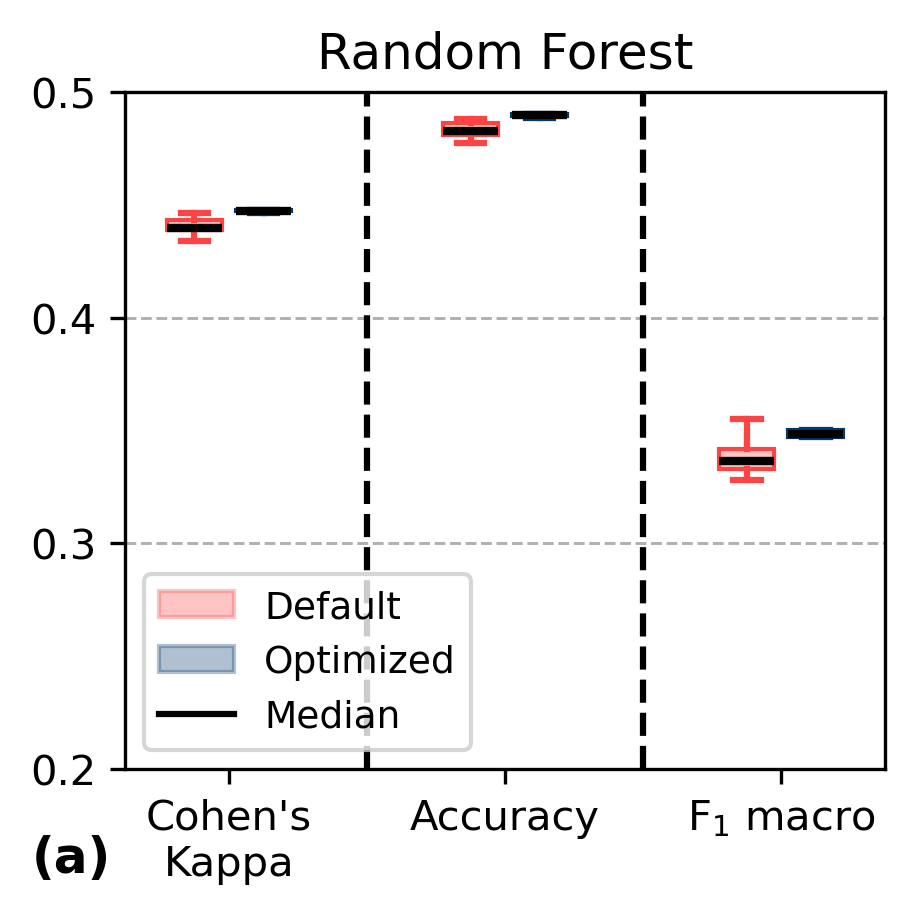

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

figsize = (8/2.54, 8/2.54)
dpi = 300
metric_names = scores.keys()
save_path = "../results/plots/rf_performance_alldata.png"

rf_color = "#FC4445"
nn_color = "#05386B"

metric_label_dict = {
    'accuracy': 'Accuracy',
    'cohen_kappa': "Cohen's\nKappa",
    'f1_macro': 'F$_{1}$ macro',
}

def set_box_color(bp, color) -> None:
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color="k") # Median in black to make it distinguishable
    
    # Prettify boxes, e.g. transparent background
    for patch in bp['boxes']:
        patch.set_facecolor(color+"50")#colors.rgb2hex(color)+"50")
    for whisker in bp['whiskers']: 
        whisker.set(linewidth=1.5)
    for cap in bp['caps']:
        cap.set(linewidth=1.5)
    for med in bp['medians']:
        med.set(linewidth=2)

# Initialize figure
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Define color ramp to use
#cmap = plt.get_cmap('jet', len(metric_df_list))    # discrete colors

n_metrics = len(metric_names)
# Calculate relative widths and positions
width = 1.2 / n_metrics

### OBS! CURRENTLY ONLY VALID FOR 2 INPUTS! FIX!
pos_list = np.arange(0, n_metrics*2, 2)
pos_rf = pos_list-0.25
pos_nn =pos_list+0.25

### Create plots
bpl_list = []

test_score_columns = ["test_"+x for x in metric_names]

### RF first
rf_default_boxes = ax.boxplot(
    pd.DataFrame(rf_cv_default)[test_score_columns],
    positions=pos_rf,  # pos_list[idx_odd]-0.25, ## ODD INDICES
    sym='',
    widths=width,
    patch_artist = True,
)

# Set color
set_box_color(rf_default_boxes, rf_color)


### NN second
rf_tuned_boxes = ax.boxplot(
    pd.DataFrame(rf_cv_tuned)[test_score_columns],
    positions=pos_nn,  # pos_list[idx_odd]-0.25, ## ODD INDICES
    sym='',
    widths=width,
    patch_artist = True,
)
'''
nn_boxes = ax.boxplot(
    nn_metrics_df[metric_names],
    positions=pos_nn,#pos_list[idx_even]+0.25, ## EVEN INDICES
    sym='',
    widths=width,
    patch_artist=
    True
)'''

# Set color
set_box_color(rf_tuned_boxes, nn_color)

### LEGEND ###
import matplotlib.patches as mpatches
# Store patches
handle_list = []

### Add RF
handle_list.append(
    mpatches.Patch(
        color=rf_color+"50",
        label="Default"
    )
)

### Add NN
handle_list.append(
    mpatches.Patch(
        color=nn_color+"50",
        label="Optimized"
    )
)

# Dummy for median as line, NOTE THE COMMA
median_legend, = ax.plot([], c='k', label='Median')
handle_list.append(median_legend)

### Add legend
ax.legend(handles=handle_list, loc='lower left', fontsize=9)

ax.set_xticks(range(0, len(metric_names)*2, 2))
ax.set_xticklabels(
    [metric_label_dict[x] for x in metric_names],
    fontsize=10
)

plt.setp(ax.get_yticklabels(), fontsize=10)


### Plot dotted line between groups
# only one line may be specified; full height
if len(metric_names) > 1:
    for pos in range(1, (len(metric_names)-1) * 2, 2):
        ax.axvline(x=pos, color='k', ls='--')

ax.set_ylim(
    0.2,
    0.5
)
ax.set_yticks([0.2, 0.3, 0.4, 0.5])

ax.grid(
    axis='y',
    linestyle='--',
    linewidth=0.7,
    zorder=-1
)

ax.set_title("Random Forest")

fig.text(
    0.05, 0.05,
    "(a)",
    ha='left',
    va='bottom',
    #transform=ax.transAxes,
    fontsize=12,
    fontweight='demibold',
)

# Update layout
fig.tight_layout()

### Save?
if save_path is not None:
    fig.savefig(save_path)

---
# Neural network

In [56]:
# Read data
vt_y_nn = pd.read_pickle("../data/processed/vt_y_fact.pkl")
vt_X_nn = pd.read_pickle(
    "../data/processed/vt_X_scaled_and_dummies_allbands.pkl"
).drop(columns=["x","y","plot_id"])

In [57]:
_ = [print(x+"; ") for x in vt_X_nn.columns]

B11_median_comp_Sent2; 
B12_median_comp_Sent2; 
B1_median_comp_Sent2; 
B2_median_comp_Sent2; 
B3_median_comp_Sent2; 
B4_median_comp_Sent2; 
B5_median_comp_Sent2; 
B6_median_comp_Sent2; 
B7_median_comp_Sent2; 
B8A_median_comp_Sent2; 
B8_median_comp_Sent2; 
B9_median_comp_Sent2; 
EVI_greenest_pixel_Sent2; 
EVI_median_comp_Sent2; 
GNDVI_greenest_pixel_Sent2; 
GNDVI_median_comp_Sent2; 
NDMI_greenest_pixel_Sent2; 
NDMI_median_comp_Sent2; 
NDVI_greenest_pixel_Sent2; 
NDVI_median_comp_Sent2; 
SAVI_greenest_pixel_Sent2; 
SAVI_median_comp_Sent2; 
B1_median_comp_Lands7; 
B2_median_comp_Lands7; 
B3_median_comp_Lands7; 
B4_median_comp_Lands7; 
B5_median_comp_Lands7; 
B6_median_comp_Lands7; 
B7_median_comp_Lands7; 
EVI_greenest_pixel_Lands7; 
EVI_median_comp_Lands7; 
GNDVI_greenest_pixel_Lands7; 
GNDVI_median_comp_Lands7; 
NDMI_greenest_pixel_Lands7; 
NDMI_median_comp_Lands7; 
NDVI_greenest_pixel_Lands7; 
NDVI_median_comp_Lands7; 
SAVI_greenest_pixel_Lands7; 
SAVI_median_comp_Lands7; 
aspect; 
bioc

In [58]:
# Get number of features and targets
n_X_cols = vt_X_nn.shape[1]
n_y_classes = len(set(vt_y_nn["vt_integer"]))
print(n_X_cols)
print(n_y_classes)

207
31


In [59]:
import tensorflow as tf
import tensorflow_addons as tfa

2023-12-09 01:27:45.953443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils

In [60]:
def build_ANN_model(
        alpha_l1=0.001, alpha_l2=0.001,
        dropout_rate=0.1, #learning_rate=0.01,
        n_nodes_l1=64, n_nodes_l2=64, # n_nodes_l3=64,
        optim_name="nadam", n_hidden_layers=1,
) -> tf.keras.Sequential:

    ### Define the keras sequential NN
    nn = tf.keras.Sequential()
    
    ### Input + hidden layer
    nn.add(
        tf.keras.layers.Dense(
            n_nodes_l1,
            input_dim=n_X_cols,
            kernel_regularizer=tf.keras.regularizers.L1L2(
                l1=alpha_l1, l2=alpha_l2
            ),
            activation='tanh',
    ))#, activation='relu'))
    #nn.add(tf.keras.layers.LeakyReLU(alpha=alpha_leaky))
    nn.add(tf.keras.layers.Dropout(dropout_rate))
    
    ### Hidden additional layers
    for _ in range(n_hidden_layers-1):
        nn.add(
            tf.keras.layers.Dense(
                n_nodes_l2, 
                kernel_regularizer=tf.keras.regularizers.L1L2(
                    l1=alpha_l1, l2=alpha_l2
                ),
                activation='tanh'
            )
        )
        if dropout_rate:
            nn.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Hidden layer no. 2
    '''
    nn.add(
        tf.keras.layers.Dense(
            n_nodes_l3,
            activation='tanh'
        )
    )#, activation='relu'))#,kernel_regularizer='l1'))
    '''

    #nn.add(tf.keras.layers.LeakyReLU(alpha=alpha_leaky))
    if dropout_rate:
        nn.add(tf.keras.layers.Dropout(dropout_rate))

    # Output layer
    nn.add(tf.keras.layers.Dense(n_y_classes, activation='softmax'))
    
    ### Compile model and define optimizer, loss, and metrics
    #optim = tf.keras.optimizers.Adamax(learning_rate = learning_rate)
    if optim_name == "sgd":
        optim = tf.keras.optimizers.SGD()#learning_rate=learning_rate)
    elif optim_name == "nadam":
        optim = tf.keras.optimizers.Nadam()#learning_rate=learning_rate)
    elif optim_name == "rmsprop":
        optim = tf.keras.optimizers.RMSprop()#learning_rate=learning_rate)
    else:
        optim = tf.keras.optimizers.RMSprop()#learning_rate=learning_rate)

    nn.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optim,
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(
                name="accuracy",
            ),
            tfa.metrics.CohenKappa(
                num_classes=n_y_classes,
                name='cohen_kappa',
                sparse_labels=True,
            ),
        ],
    )
    
    return nn

In [62]:
# NN cv
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",  #"sparse_categorical_accuracy",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

# USING sklearn.neural_network.MLPClassifier DEFAULT VALUES
nn_default = tf.keras.wrappers.scikit_learn.KerasClassifier(
    build_fn=build_ANN_model,
    n_hidden_layers=1,
    n_nodes_l1=100,
    alpha_l2=0.0001,
    dropout_rate=0,
    epochs=100,
    callbacks=[early_stopper],
    workers=10,
    use_multiprocessing=True,
    verbose=1,
)

nn_cv_default = cross_validate(
    estimator=nn_default,
    X=vt_X_nn.astype('float32'),
    y=vt_y_nn.astype('int'),
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=10
)

# END

/tmp/ipykernel_3331652/3305540749.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_default = tf.keras.wrappers.scikit_learn.KerasClassifier(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


2023-12-09 01:38:21.075388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 01:38:21.075465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 01:38:21.075464: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
555/555 [==============================] - 5s 7ms/step - loss: 2.9662 - accuracy: 0.3057 - cohen_kappa: 0.2364
Epoch 2/100
555/555 [==============================] - 8s 12ms/step - loss: 2.9492 - accuracy: 0.3133 - cohen_kappa: 0.2450
Epoch 2/100
555/555 [==============================] - 4s 8ms/step - loss: 2.3649 - accuracy: 0.3477 - cohen_kappa: 0.2885
Epoch 3/100
555/555 [==============================] - 6s 10ms/step - loss: 2.3520 - accuracy: 0.3517 - cohen_kappa: 0.2920
Epoch 3/100
555/555 [==============================] - 5s 9ms/step - loss: 2.3572 - accuracy: 0.3510 - cohen_kappa: 0.2916
Epoch 3/100
555/555 [==============================] - 5s 9ms/step - loss: 2.3515 - accuracy: 0.3546 - cohen_kappa: 0.2956
Epoch 3/100
555/555 [==============================] - 6s 11ms/step - loss: 2.3528 - accuracy: 0.3485 - cohen_kappa: 0.2877
Epoch 3/100
555/555 [==============================] - 4s 8ms/step - loss: 2.2394 - accu

2023-12-09 01:41:23.283613: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


555/555 [==============================] - 4s 8ms/step - loss: 1.8536 - accuracy: 0.4281 - cohen_kappa: 0.3811
Epoch 39/100
555/555 [==============================] - 3s 5ms/step - loss: 1.8534 - accuracy: 0.4274 - cohen_kappa: 0.3806
Epoch 45/100
555/555 [==============================] - 4s 7ms/step - loss: 1.8497 - accuracy: 0.4250 - cohen_kappa: 0.3769
Epoch 42/100
555/555 [==============================] - 4s 7ms/step - loss: 1.8505 - accuracy: 0.4276 - cohen_kappa: 0.3805
Epoch 40/100
555/555 [==============================] - 3s 5ms/step - loss: 1.8498 - accuracy: 0.4242 - cohen_kappa: 0.3775
Epoch 46/100
555/555 [==============================] - 3s 6ms/step - loss: 1.8508 - accuracy: 0.4269 - cohen_kappa: 0.3793
Epoch 43/100
555/555 [==============================] - 3s 5ms/step - loss: 1.8489 - accuracy: 0.4253 - cohen_kappa: 0.3785
Epoch 47/100
555/555 [==============================] - 4s 7ms/step - loss: 1.8479 - accuracy: 0.4261 - cohen_kappa: 0.3791
Epoch 41/100
555/555 

[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  6.2min finished


"\nsearch_spaces={\n        'n_hidden_layers': Integer(low=1, high=2, prior='uniform'),\n        'dropout_rate': Real(low=0.01, high=0.2, prior='uniform'),\n        'n_nodes_l1': Integer(low=16, high=64, prior='uniform'),\n        'n_nodes_l2': Integer(low=16, high=64, prior='uniform'),\n        'optim_name': Categorical(['sgd', 'nadam', 'rmsprop']),\n        'alpha_l1': Real(low=0.0001, high=0.01, prior='log-uniform'),\n        'alpha_l2': Real(low=0.0001, high=0.01, prior='log-uniform'),\n        #'learning_rate': Real(low=0.001, high=0.01, prior='log-uniform'),\n    }\n# TUNED\nrf_tuned = RandomForestClassifier(\n    n_estimators=int(rf_optim_df.loc[rf_optim_df['rank_test_score']==1, 'param_n_estimators'].values),#645,\n    class_weight=None,\n    criterion=rf_optim_df.loc[rf_optim_df['rank_test_score']==1, 'param_criterion'].values[0],\n    max_depth=int(rf_optim_df.loc[rf_optim_df['rank_test_score']==1, 'param_max_depth'].values[0]),#27,\n    max_features=int(rf_optim_df.loc[rf_op

In [63]:
nn_cv_default

{'fit_time': array([316.24395919, 208.59331346, 176.67786288, 171.87274528,
        360.7013979 ]),
 'score_time': array([0.78961611, 1.63209224, 2.04732847, 1.69650698, 0.44906592]),
 'estimator': [<keras.wrappers.scikit_learn.KerasClassifier at 0x7f7e884a9e90>,
 'test_cohen_kappa': array([0.36933737, 0.35936484, 0.35074428, 0.32486598, 0.3864736 ]),
 'train_cohen_kappa': array([0.40095453, 0.3899841 , 0.38714642, 0.37308459, 0.40985216]),
 'test_accuracy': array([0.41668546, 0.40473506, 0.39706877, 0.37573297, 0.43369418]),
 'train_accuracy': array([0.44492051, 0.43544932, 0.43155936, 0.4201477 , 0.45177293]),
 'test_f1_macro': array([0.28098418, 0.24176418, 0.25440985, 0.2333482 , 0.27150718]),
 'train_f1_macro': array([0.32078171, 0.31703479, 0.28168662, 0.27373509, 0.32240687])}

In [64]:
# TUNED
nn_tuned = tf.keras.wrappers.scikit_learn.KerasClassifier(
    build_fn=build_ANN_model,
    n_hidden_layers=int(nn_optim_df.loc[nn_optim_df['rank_test_score']==1, 'param_n_hidden_layers'].values),
    n_nodes_l1=int(nn_optim_df.loc[nn_optim_df['rank_test_score']==1, 'param_n_nodes_l1'].values),
    n_nodes_l2=int(nn_optim_df.loc[nn_optim_df['rank_test_score']==1, 'param_n_nodes_l2'].values),
    alpha_l1=float(nn_optim_df.loc[nn_optim_df['rank_test_score']==1, 'param_alpha_l1'].values),
    alpha_l2=float(nn_optim_df.loc[nn_optim_df['rank_test_score']==1, 'param_alpha_l2'].values),
    dropout_rate=float(nn_optim_df.loc[nn_optim_df['rank_test_score']==1, 'param_dropout_rate'].values),
    optim_name=str(nn_optim_df.loc[nn_optim_df['rank_test_score']==1, 'param_optim_name'].values),
    epochs=100,
    callbacks=[early_stopper],
    workers=10,
    use_multiprocessing=True,
    verbose=1,
)

nn_cv_tuned = cross_validate(
    estimator=nn_tuned,
    X=vt_X_nn.astype('float32'),
    y=vt_y_nn.astype('int'),
    scoring=scores,
    return_train_score=True,
    error_score=0,
    cv=split_indices,
    verbose=2,
    return_estimator=True,
    n_jobs=10
)

/tmp/ipykernel_3331652/1812870959.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_tuned = tf.keras.wrappers.scikit_learn.KerasClassifier(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
2023-12-09 01:50:51.045130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end o

Epoch 1/100
 11/555 [..............................] - ETA: 9s - loss: 3.3925 - accuracy: 0.1136 - cohen_kappa: 0.0174      

2023-12-09 01:50:55.084279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 01:50:55.109842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 01:50:55.127459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09

555/555 [==============================] - 3s 3ms/step - loss: 2.4327 - accuracy: 0.2932 - cohen_kappa: 0.2187
Epoch 2/100
555/555 [==============================] - 2s 3ms/step - loss: 2.1091 - accuracy: 0.3514 - cohen_kappa: 0.2928
Epoch 3/100
440/555 [======================>.......] - ETA: 0s - loss: 2.0162 - accuracy: 0.3738 - cohen_kappa: 0.3182

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might no

492/555 [=========================>....] - ETA: 0s - loss: 2.0130 - accuracy: 0.3742 - cohen_kappa: 0.3185

2023-12-09 01:50:59.956856: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 11. Tune using inter_op_parallelism_threads for best performance.
/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal 

531/555 [===========================>..] - ETA: 0s - loss: 2.0115 - accuracy: 0.3734 - cohen_kappa: 0.3179

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might no

555/555 [==============================] - 2s 4ms/step - loss: 2.0115 - accuracy: 0.3731 - cohen_kappa: 0.3179
Epoch 4/100
125/555 [=====>........................] - ETA: 1s - loss: 1.9476 - accuracy: 0.3825 - cohen_kappa: 0.3288Epoch 1/100
Epoch 1/100
555/555 [==============================] - 4s 6ms/step - loss: 1.9137 - accuracy: 0.3979 - cohen_kappa: 0.3463
Epoch 6/100
555/555 [==============================] - 6s 8ms/step - loss: 2.4528 - accuracy: 0.2840 - cohen_kappa: 0.2102
Epoch 2/100
555/555 [==============================] - 6s 8ms/step - loss: 2.4551 - accuracy: 0.2780 - cohen_kappa: 0.1994
Epoch 2/100
555/555 [==============================] - 6s 9ms/step - loss: 2.4512 - accuracy: 0.2867 - cohen_kappa: 0.2099
Epoch 2/100
555/555 [==============================] - 2s 4ms/step - loss: 2.1248 - accuracy: 0.3484 - cohen_kappa: 0.2905
Epoch 3/100
555/555 [==============================] - 3s 5ms/step - loss: 2.1297 - accuracy: 0.3360 - cohen_kappa: 0.2749
Epoch 3/100
555/555 [

[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  5.7min finished


In [65]:
nn_cv_tuned

{'fit_time': array([336.05411649, 309.23668766, 275.83078098, 225.3871839 ,
        317.70976853]),
 'score_time': array([0.57848287, 1.43720722, 1.82673645, 1.66977119, 0.84087801]),
 'estimator': [<keras.wrappers.scikit_learn.KerasClassifier at 0x7f7e88433c90>,
 'test_cohen_kappa': array([0.37667412, 0.38588255, 0.3598188 , 0.36385643, 0.39957171]),
 'train_cohen_kappa': array([0.44192822, 0.42093771, 0.42483877, 0.43292181, 0.43691396]),
 'test_accuracy': array([0.42367531, 0.43089064, 0.40901917, 0.41046459, 0.44722598]),
 'train_accuracy': array([0.48263615, 0.46572331, 0.4690495 , 0.47364564, 0.47770449]),
 'test_f1_macro': array([0.28745361, 0.25397703, 0.26894557, 0.26007925, 0.28778598]),
 'train_f1_macro': array([0.34721131, 0.33831041, 0.33734059, 0.3367322 , 0.356759  ])}

In [79]:
## Save all results
pd.DataFrame(rf_cv_default).to_csv("../results/hyperparam_search/default_rf_5fcv.csv")
pd.DataFrame(rf_cv_tuned).to_csv("../results/hyperparam_search/tuned_rf_5fcv.csv")
pd.DataFrame(nn_cv_default).to_csv("../results/hyperparam_search/default_mlp_5fcv.csv")
pd.DataFrame(nn_cv_tuned).to_csv("../results/hyperparam_search/tuned_mlp_5fcv.csv")

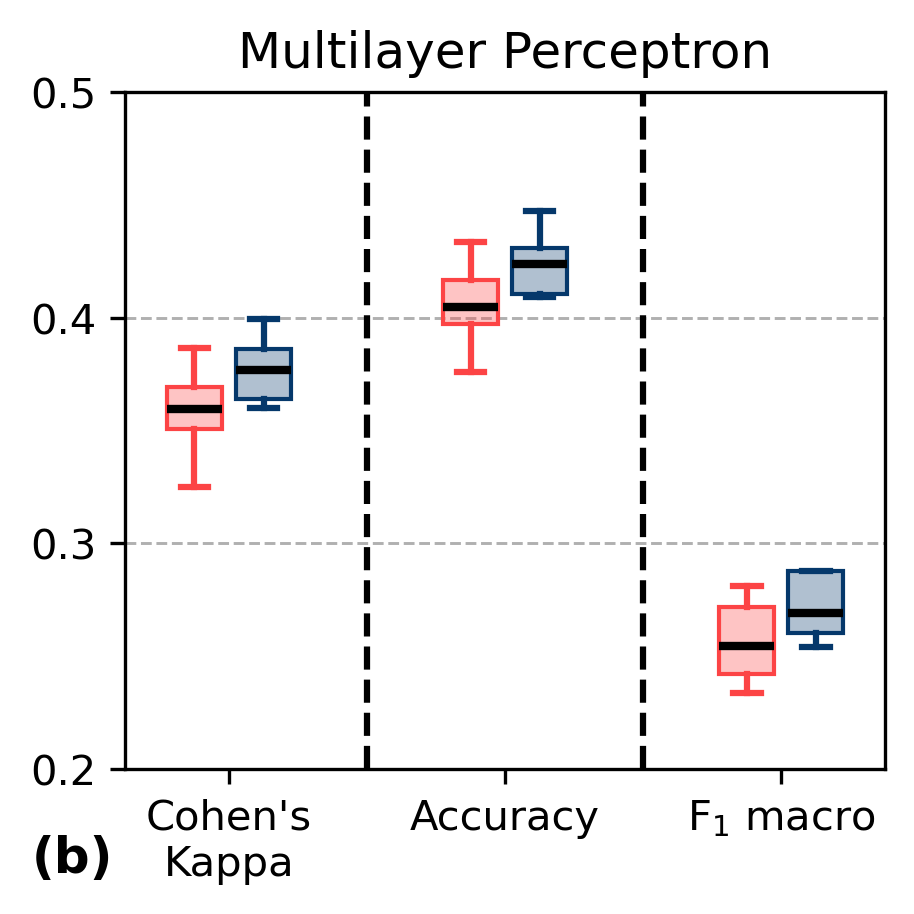

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

figsize = (8/2.54, 8/2.54)
dpi = 300
metric_names = scores.keys()
save_path = "../results/plots/nn_performance_alldata.png"

rf_color = "#FC4445"
nn_color = "#05386B"

metric_label_dict = {
    'accuracy': 'Accuracy',
    'cohen_kappa': "Cohen's\nKappa",
    'f1_macro': 'F$_{1}$ macro',
}

def set_box_color(bp, color) -> None:
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color="k") # Median in black to make it distinguishable
    
    # Prettify boxes, e.g. transparent background
    for patch in bp['boxes']:
        patch.set_facecolor(color+"50")#colors.rgb2hex(color)+"50")
    for whisker in bp['whiskers']: 
        whisker.set(linewidth=1.5)
    for cap in bp['caps']:
        cap.set(linewidth=1.5)
    for med in bp['medians']:
        med.set(linewidth=2)

# Initialize figure
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Define color ramp to use
#cmap = plt.get_cmap('jet', len(metric_df_list))    # discrete colors

n_metrics = len(metric_names)
# Calculate relative widths and positions
width = 1.2 / n_metrics

### OBS! CURRENTLY ONLY VALID FOR 2 INPUTS! FIX!
pos_list = np.arange(0, n_metrics*2, 2)
pos_rf = pos_list-0.25
pos_nn =pos_list+0.25

### Create plots
bpl_list = []

test_score_columns = ["test_"+x for x in metric_names]

### RF first
nn_default_boxes = ax.boxplot(
    pd.DataFrame(nn_cv_default)[test_score_columns],
    positions=pos_rf,  # pos_list[idx_odd]-0.25, ## ODD INDICES
    sym='',
    widths=width,
    patch_artist = True,
)

# Set color
set_box_color(nn_default_boxes, rf_color)


### NN second
nn_tuned_boxes = ax.boxplot(
    pd.DataFrame(nn_cv_tuned)[test_score_columns],
    positions=pos_nn,  # pos_list[idx_odd]-0.25, ## ODD INDICES
    sym='',
    widths=width,
    patch_artist = True,
)
'''
nn_boxes = ax.boxplot(
    nn_metrics_df[metric_names],
    positions=pos_nn,#pos_list[idx_even]+0.25, ## EVEN INDICES
    sym='',
    widths=width,
    patch_artist=
    True
)'''

# Set color
set_box_color(nn_tuned_boxes, nn_color)

### LEGEND ###
import matplotlib.patches as mpatches
# Store patches
handle_list = []

### Add RF
handle_list.append(
    mpatches.Patch(
        color=rf_color+"50",
        label="Default"
    )
)

### Add NN
handle_list.append(
    mpatches.Patch(
        color=nn_color+"50",
        label="Optimized"
    )
)

# Dummy for median as line, NOTE THE COMMA
median_legend, = ax.plot([], c='k', label='Median')
handle_list.append(median_legend)

### Add legend
#ax.legend(handles=handle_list, loc='lower left', fontsize=9)

ax.set_xticks(range(0, len(metric_names)*2, 2))
ax.set_xticklabels(
    [metric_label_dict[x] for x in metric_names],
    fontsize=10
)

plt.setp(ax.get_yticklabels(), fontsize=10)


### Plot dotted line between groups
# only one line may be specified; full height
if len(metric_names) > 1:
    for pos in range(1, (len(metric_names)-1) * 2, 2):
        ax.axvline(x=pos, color='k', ls='--')

ax.set_ylim(
    0.2,
    0.5
)
ax.set_yticks([0.2, 0.3, 0.4, 0.5])

ax.grid(
    axis='y',
    linestyle='--',
    linewidth=0.7,
    zorder=-1
)

ax.set_title("Multilayer Perceptron")

fig.text(
    0.05, 0.05,
    "(b)",
    ha='left',
    va='bottom',
    #transform=ax.transAxes,
    fontsize=12,
    fontweight='demibold',
)

# Update layout
fig.tight_layout()

### Save?
if save_path is not None:
    fig.savefig(save_path)

---
## NN Hyper tuning

In [37]:
### Set up neural network
nn = build_ANN_model()

In [42]:
# Set up EarlyStopping
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [40]:
history = nn.fit(
    x=np.asarray(vt_X_nn.iloc[split_indices[0][0],:]).astype('float32'),
    y=np.asarray(vt_y_nn.iloc[split_indices[0][0]]).astype('int'),
    validation_data=(
        np.asarray(vt_X_nn.iloc[split_indices[0][1],:]).astype('float32'),
        np.asarray(vt_y_nn.iloc[split_indices[0][1]]).astype('int')
    ),
    callbacks=[early_stopper],
    epochs=10,
    verbose=1,
    workers=10,
    use_multiprocessing=True,
) # Should be at least 300 epochs

Epoch 1/10
555/555 [==============================] - 38s 67ms/step - loss: 2.5515 - sparse_categorical_accuracy: 0.3114 - val_loss: 2.5071 - val_sparse_categorical_accuracy: 0.3258
Epoch 2/10
555/555 [==============================] - 36s 64ms/step - loss: 2.3890 - sparse_categorical_accuracy: 0.3353 - val_loss: 2.4288 - val_sparse_categorical_accuracy: 0.3209
Epoch 3/10
555/555 [==============================] - 37s 67ms/step - loss: 2.3441 - sparse_categorical_accuracy: 0.3461 - val_loss: 2.3510 - val_sparse_categorical_accuracy: 0.3470
Epoch 4/10
555/555 [==============================] - 41s 73ms/step - loss: 2.3053 - sparse_categorical_accuracy: 0.3533 - val_loss: 2.2687 - val_sparse_categorical_accuracy: 0.3572
Epoch 5/10
555/555 [==============================] - 36s 66ms/step - loss: 2.2909 - sparse_categorical_accuracy: 0.3528 - val_loss: 2.2586 - val_sparse_categorical_accuracy: 0.3522
Epoch 6/10
555/555 [==============================] - 39s 71ms/step - loss: 2.2684 - spars

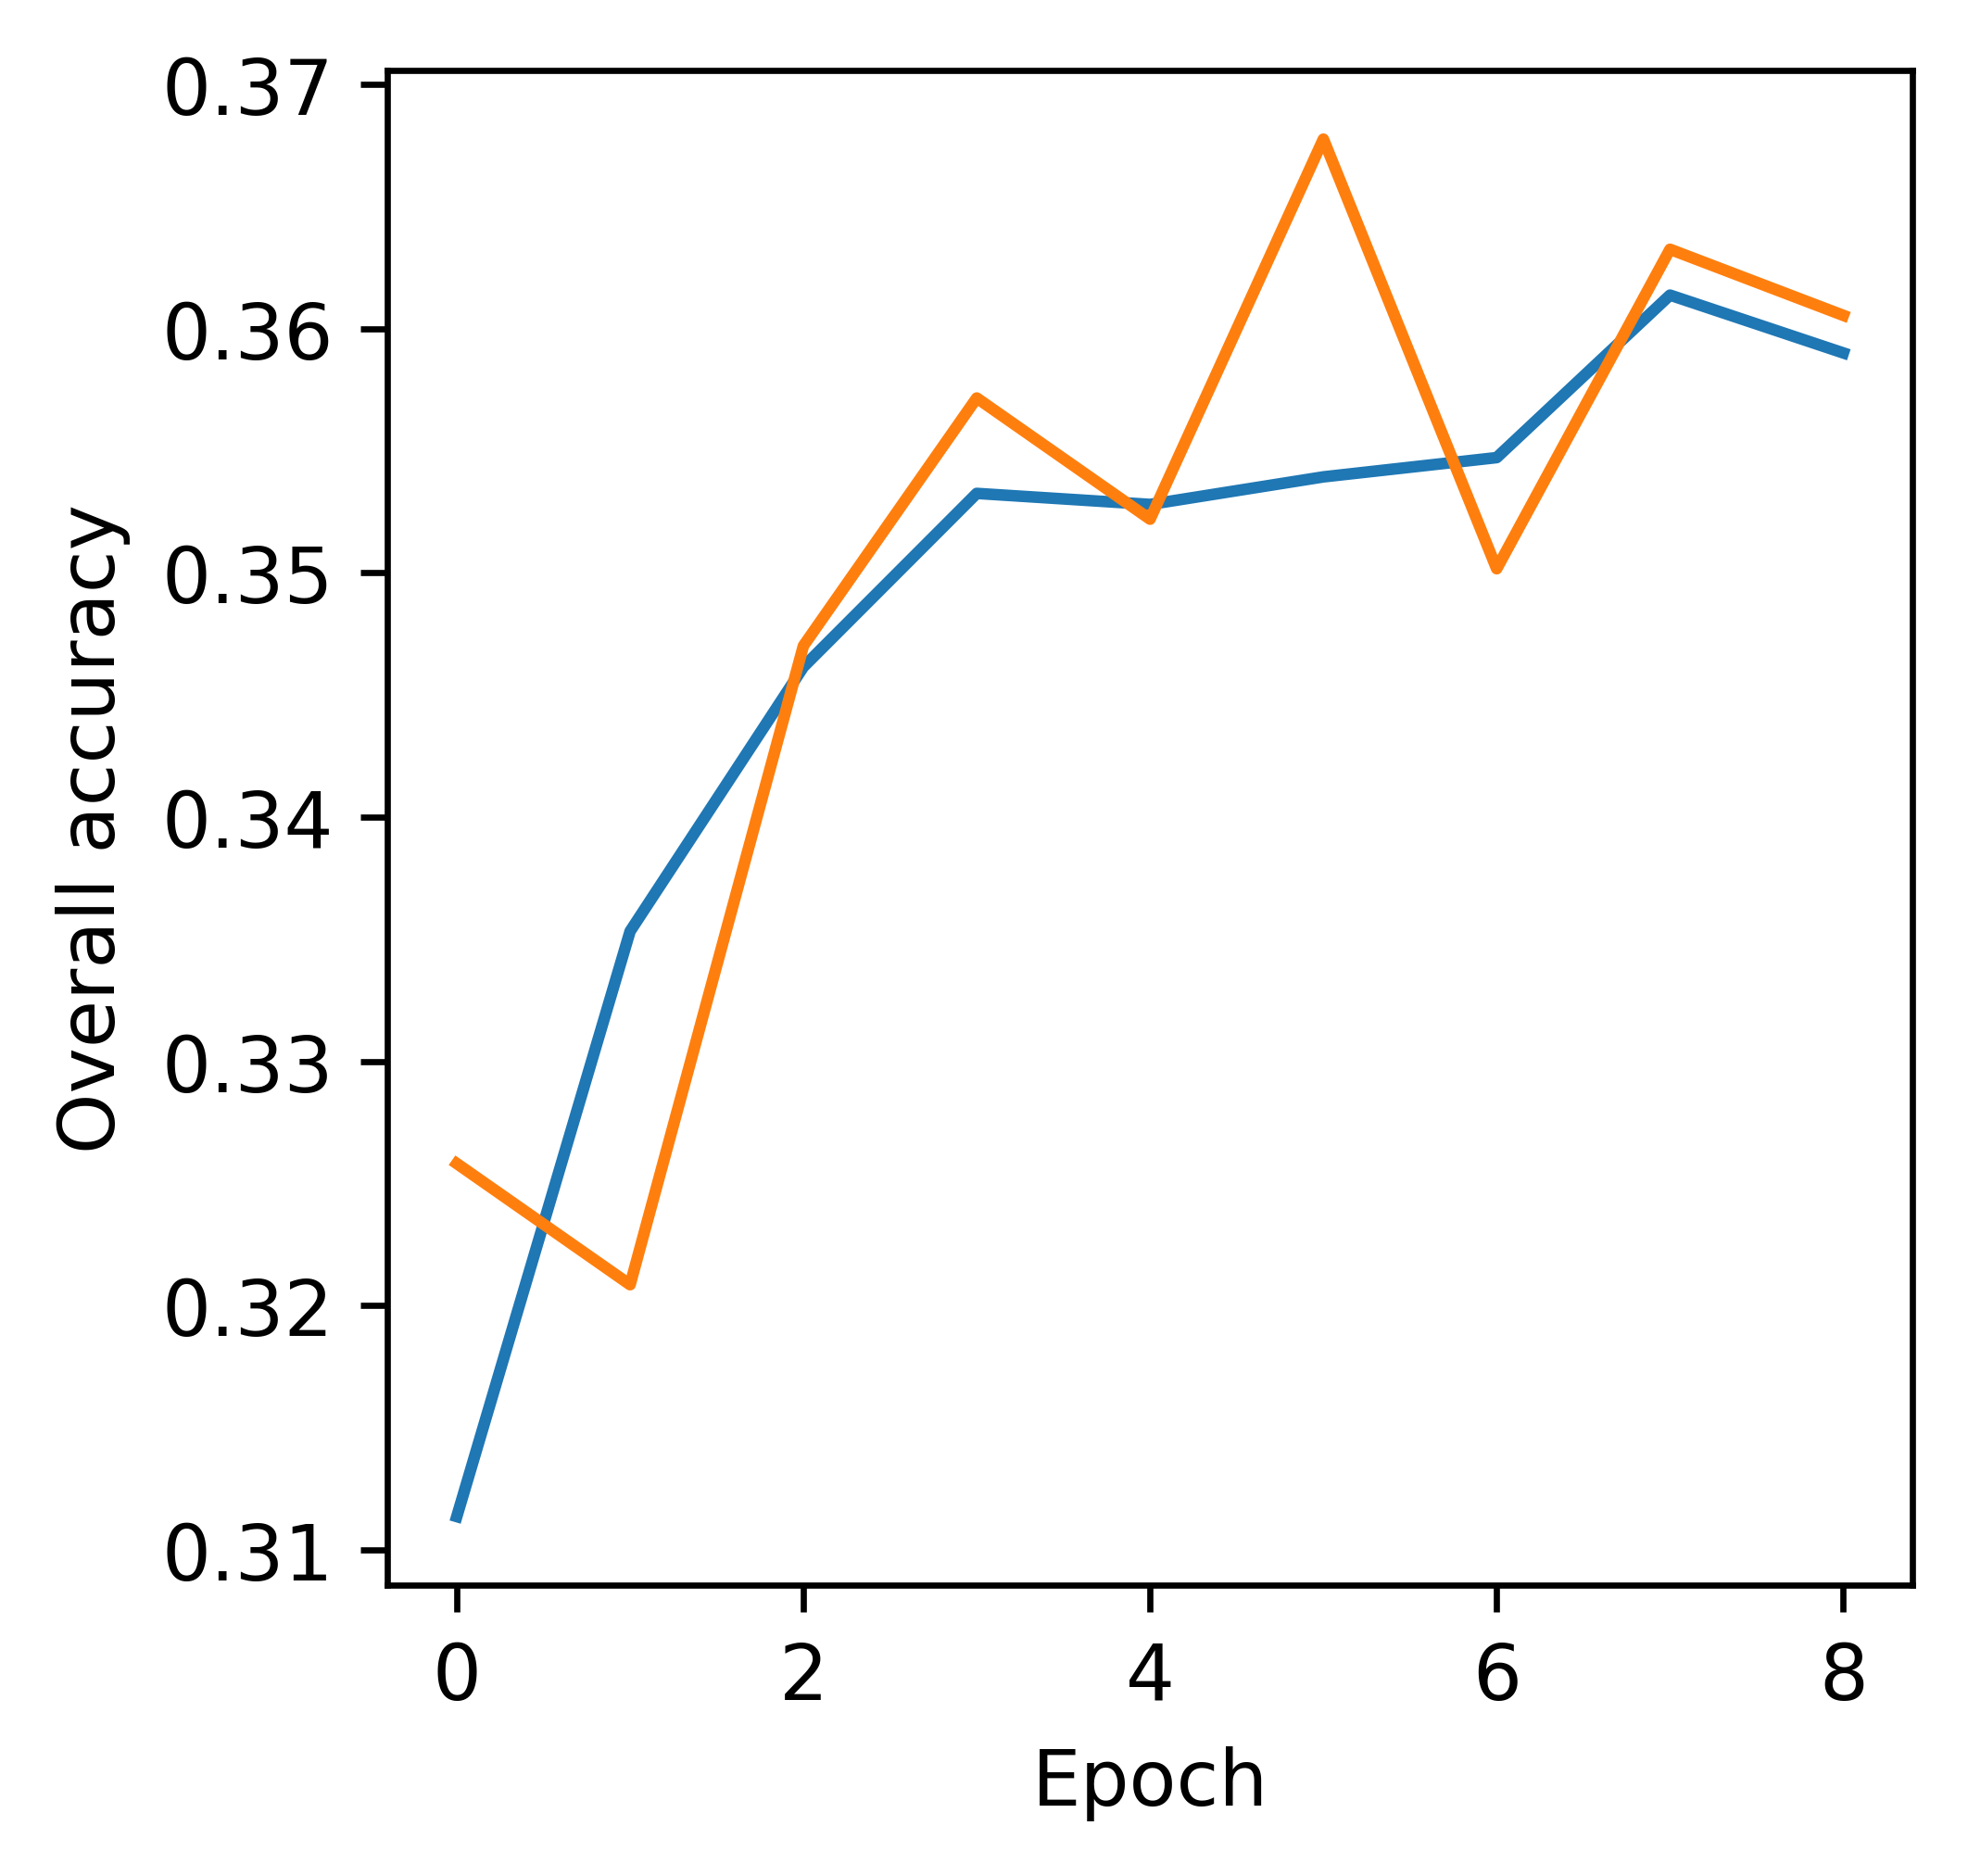

In [41]:
import matplotlib.pyplot as plt
# plot accuracy for NN training steps
fig, ax = plt.subplots(figsize=(3.54, 3.54), dpi=600)

ax.set_ylabel('Overall accuracy')
ax.set_xlabel('Epoch')
ax.plot(history.history['sparse_categorical_accuracy'], label='train')
ax.plot(history.history['val_sparse_categorical_accuracy'], label='test')

In [14]:
# CV search
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",  #"sparse_categorical_accuracy",
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

nn_sklearn = tf.keras.wrappers.scikit_learn.KerasClassifier(
    build_fn=build_ANN_model,
    epochs=1,
    callbacks=[early_stopper],
    workers=10,
    use_multiprocessing=True,
    verbose=1,
)

/tmp/ipykernel_2113648/4154910465.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_sklearn = tf.keras.wrappers.scikit_learn.KerasClassifier(


In [15]:
optimized_nn = BayesSearchCV(
    estimator=nn_sklearn,
    search_spaces={
        'n_hidden_layers': Integer(low=1, high=2, prior='uniform'),
        'dropout_rate': Real(low=0.01, high=0.2, prior='uniform'),
        'n_nodes_l1': Integer(low=16, high=64, prior='uniform'),
        'n_nodes_l2': Integer(low=16, high=64, prior='uniform'),
        'optim_name': Categorical(['sgd', 'nadam', 'rmsprop']),
        'alpha_l1': Real(low=0.0001, high=0.01, prior='log-uniform'),
        'alpha_l2': Real(low=0.0001, high=0.01, prior='log-uniform'),
        #'learning_rate': Real(low=0.001, high=0.01, prior='log-uniform'),
    },
    n_jobs=10,
    n_iter=2,
    cv=split_indices,
    random_state=221,
    verbose=2,
    #scoring=scores,
    #refit=False,#'accuracy',
    return_train_score=True,
)

# Fit to data
optimized_nn.fit(
    vt_X_nn.astype('float32'),
    vt_y_nn.astype('int'),
)

try:
    with open("../results/hyperparam_search/nn_5fcv_bayes_optim.pkl", 'wb') as pkl_file:
        pickle.dump(
            optimized_nn,
            pkl_file,
            protocol=pickle.HIGHEST_PROTOCOL
        )
except Exception as e:
    print(e)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2023-12-08 01:12:59.229969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 01:12:59.229969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 01:12:59.234405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08

139/139 [==============================] - 2s 8ms/step - loss: 2.4653 - accuracy: 0.3356 - cohen_kappa: 0.2665
[CV] END alpha_l1=0.001323179288567648, alpha_l2=0.0012710198061317921, dropout_rate=0.08021573231528811, n_hidden_layers=1, n_nodes_l1=36, n_nodes_l2=20, optim_name=nadam; total time=  12.6s
139/139 [==============================] - 1s 3ms/step - loss: 2.4750 - accuracy: 0.3269 - cohen_kappa: 0.2648
[CV] END alpha_l1=0.001323179288567648, alpha_l2=0.0012710198061317921, dropout_rate=0.08021573231528811, n_hidden_layers=1, n_nodes_l1=36, n_nodes_l2=20, optim_name=nadam; total time=  13.3s
139/139 [==============================] - 1s 5ms/step - loss: 2.4787 - accuracy: 0.3103 - cohen_kappa: 0.2403
[CV] END alpha_l1=0.001323179288567648, alpha_l2=0.0012710198061317921, dropout_rate=0.08021573231528811, n_hidden_layers=1, n_nodes_l1=36, n_nodes_l2=20, optim_name=nadam; total time=  14.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


2023-12-08 01:13:16.095707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 01:13:16.104403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 01:13:16.127253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08

501/555 [==========================>...] - ETA: 0s - loss: 3.1028 - accuracy: 0.2665 - cohen_kappa: 0.1929[CV] END alpha_l1=0.001043557368429894, alpha_l2=0.0005728594812126984, dropout_rate=0.14487700449834653, n_hidden_layers=2, n_nodes_l1=39, n_nodes_l2=60, optim_name=nadam; total time=  11.2s
[CV] END alpha_l1=0.001043557368429894, alpha_l2=0.0005728594812126984, dropout_rate=0.14487700449834653, n_hidden_layers=2, n_nodes_l1=39, n_nodes_l2=60, optim_name=nadam; total time=  11.2s
[CV] END alpha_l1=0.001043557368429894, alpha_l2=0.0005728594812126984, dropout_rate=0.14487700449834653, n_hidden_layers=2, n_nodes_l1=39, n_nodes_l2=60, optim_name=nadam; total time=  11.2s
139/139 [==============================] - 1s 5ms/step - loss: 2.6188 - accuracy: 0.3407 - cohen_kappa: 0.2781
[CV] END alpha_l1=0.001043557368429894, alpha_l2=0.0005728594812126984, dropout_rate=0.14487700449834653, n_hidden_layers=2, n_nodes_l1=39, n_nodes_l2=60, optim_name=nadam; total time=  12.4s
139/139 [======

2023-12-08 01:13:31.342152: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


693/693 [==============================] - 41s 56ms/step - loss: 2.9740 - accuracy: 0.2784 - cohen_kappa: 0.2057


In [37]:
# Load pickle from file
import dill as pickle

with open(
        "../results/test.pkl", # hyperparam_search/nn_5fcv_bayes_n50_optim.pkl",
        'rb',
) as pkl_file:
        test = pickle.load(pkl_file)

2023-12-08 15:49:55.229234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 15:49:57.192497: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 


In [36]:
pd.DataFrame(optimized_rf.cv_results_).to_csv("../results/test.csv")

In [23]:
vars(optimized_rf)

{'search_spaces': {'n_estimators': Integer(low=50, high=800, prior='uniform', transform='normalize'),
  'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
  'class_weight': Categorical(categories=('balanced', None), prior=None),
  'max_depth': Integer(low=5, high=30, prior='uniform', transform='normalize'),
  'max_features': Integer(low=6, high=12, prior='uniform', transform='normalize')},
 'n_iter': 50,
 'n_points': 1,
 'random_state': 221,
 'optimizer_kwargs': None,
 'fit_params': None,
 'iid': 'deprecated',
 'scoring': None,
 'estimator': RandomForestClassifier(n_jobs=10, oob_score=True),
 'n_jobs': 10,
 'refit': True,
 'cv': [(array([    0,     1,     3, ..., 22168, 22169, 22170]),
   array([    2,     7,     9, ..., 22157, 22171, 22172])),
  (array([    0,     1,     2, ..., 22170, 22171, 22172]),
   array([   14,    58,    67, ..., 22158, 22166, 22167])),
  (array([    0,     1,     2, ..., 22168, 22171, 22172]),
   array([   11,    12,    23, ..., 22164, 22169